Plot several visualizations which could be used to analyze the model performance:
- a confusion matrix for technique classification predictions;
- a barplot with infromation about proportions of propaganda classes in train and dev datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from  matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [2]:
# A file with a header which has a column "label"
TRAIN_LABELS = "../data/tc-train.tsv"
# A file without a header with gold standard labels
DEV_TRUE_LABELS = "../data/dev-task-TC.labels"
# A file without a header with predicted labels
DEV_PRED_LABELS = "../data/labels_dev.txt"

# Confusion matrix

Read true and predicted labels from the files.  

In [3]:
y_true = pd.read_csv(DEV_TRUE_LABELS, sep="\t", header=None)[1].tolist()
y_pred = pd.read_csv(DEV_PRED_LABELS, sep="\t", header=None)[1].tolist()

Create a mapping: class - int.  

In [4]:
class_names = sorted(list(set(y_true)))
class_dict = dict([(class_names[idx], idx) for idx in range(len(class_names))])

Transform labels to the corresponding numerical representations.

In [5]:
y_true_int = [class_dict[value] for value in y_true]
y_pred_int = [class_dict[value] for value in y_pred]

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred).astype(np.int32)
    # Compute normalized confusion matrix
    ncm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ncm = np.around(ncm, decimals=3)
    
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1, style="whitegrid")
    ax = sns.heatmap(annot=cm, 
                     data=ncm, 
                     cmap="YlGnBu",
                     fmt="d",
                     linewidths=1,
                     square=True,
                     xticklabels=classes, 
                     yticklabels=classes)

        
    return ax

Plot data and save the figure to the file

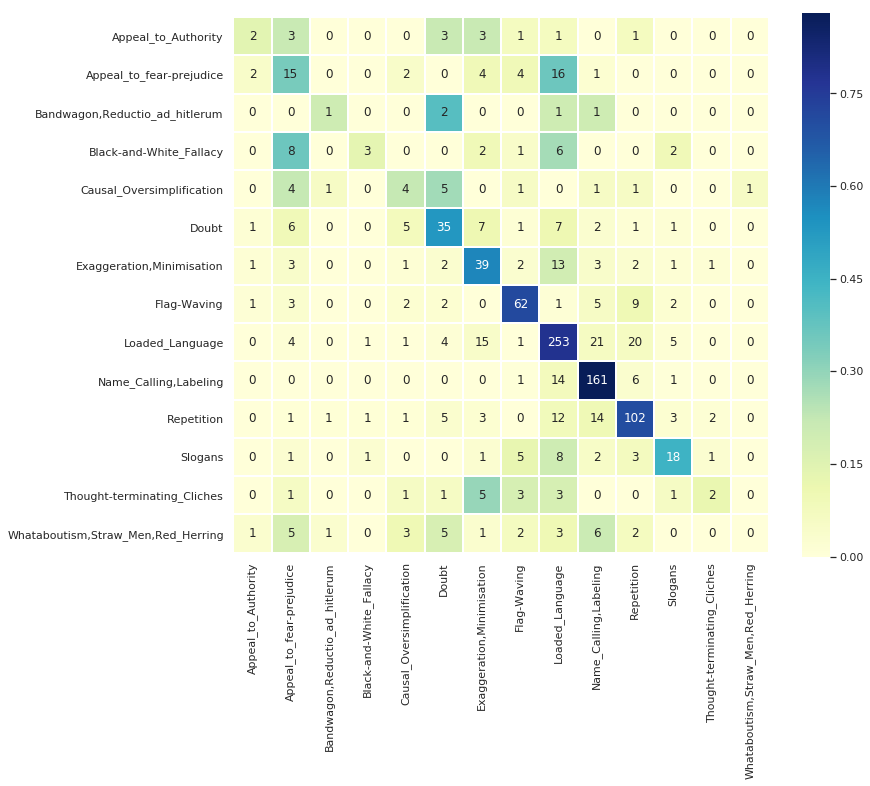

In [7]:
np.set_printoptions(precision=2)

plot_confusion_matrix(y_true_int, y_pred_int, classes=class_names)
plt.savefig("confusion-matrix.svg", format="svg", bbox_inches='tight')

# Bar plot

Read train and development data.

In [8]:
train_df = pd.read_csv(TRAIN_LABELS, sep="\t", header=0)
dev_df = pd.read_csv(DEV_TRUE_LABELS, sep="\t", header=None)

In [9]:
def plot_class_proportions(train_df, dev_df):
    # Form the dataframes with two columns: label - dataset
    train_labels = pd.DataFrame(train_df["label"]) # pick the label column from the first dataset
    train_labels["dataset"] = "train"
    dev_labels = pd.DataFrame(dev_df[1])
    dev_labels = dev_labels.rename(columns={1: "label"}) # pick the label column from the second dataset
    dev_labels["dataset"] = "dev"
    
    # Create a new combined dataframe
    frames = pd.concat([train_labels, dev_labels])
    
    # Get the count of each class depending on the dataset
    data_list = list(frames.itertuples(index=False, name=None))
    data_dict = {}
    for (y, dataset) in data_list:
        if dataset not in data_dict.keys():
            data_dict[dataset] = {}
        if y not in data_dict[dataset].keys():
            data_dict[dataset][y] = 0
        data_dict[dataset][y] = data_dict[dataset][y] + 1
        
    # Add normlized values to the information from data_dict and 
    # crete the list which is used in the final plot
    train_size = train_labels.shape[0]
    dev_size = dev_labels.shape[0]
    output_data_list = []

    for dataset in data_dict.keys():
        for label in data_dict[dataset].keys():
            count = data_dict[dataset][label]
            if dataset == "train":
                normalized_count = count / train_size
            else:
                normalized_count = count / dev_size
            output_data_list.append((label, count, round(normalized_count, 3), dataset))
    
    output_df = pd.DataFrame(output_data_list, columns=["label", "count", "proportion", "dataset"])
    output_df = output_df.sort_values(by=['proportion'], ascending=False)
    
    plt.figure(figsize=(20, 15))
    sns.set(font_scale=2, style="whitegrid")
    ax = sns.barplot(x="proportion", y="label", hue="dataset", data=output_df)
    
    return ax

Plot data and save the figure to the file

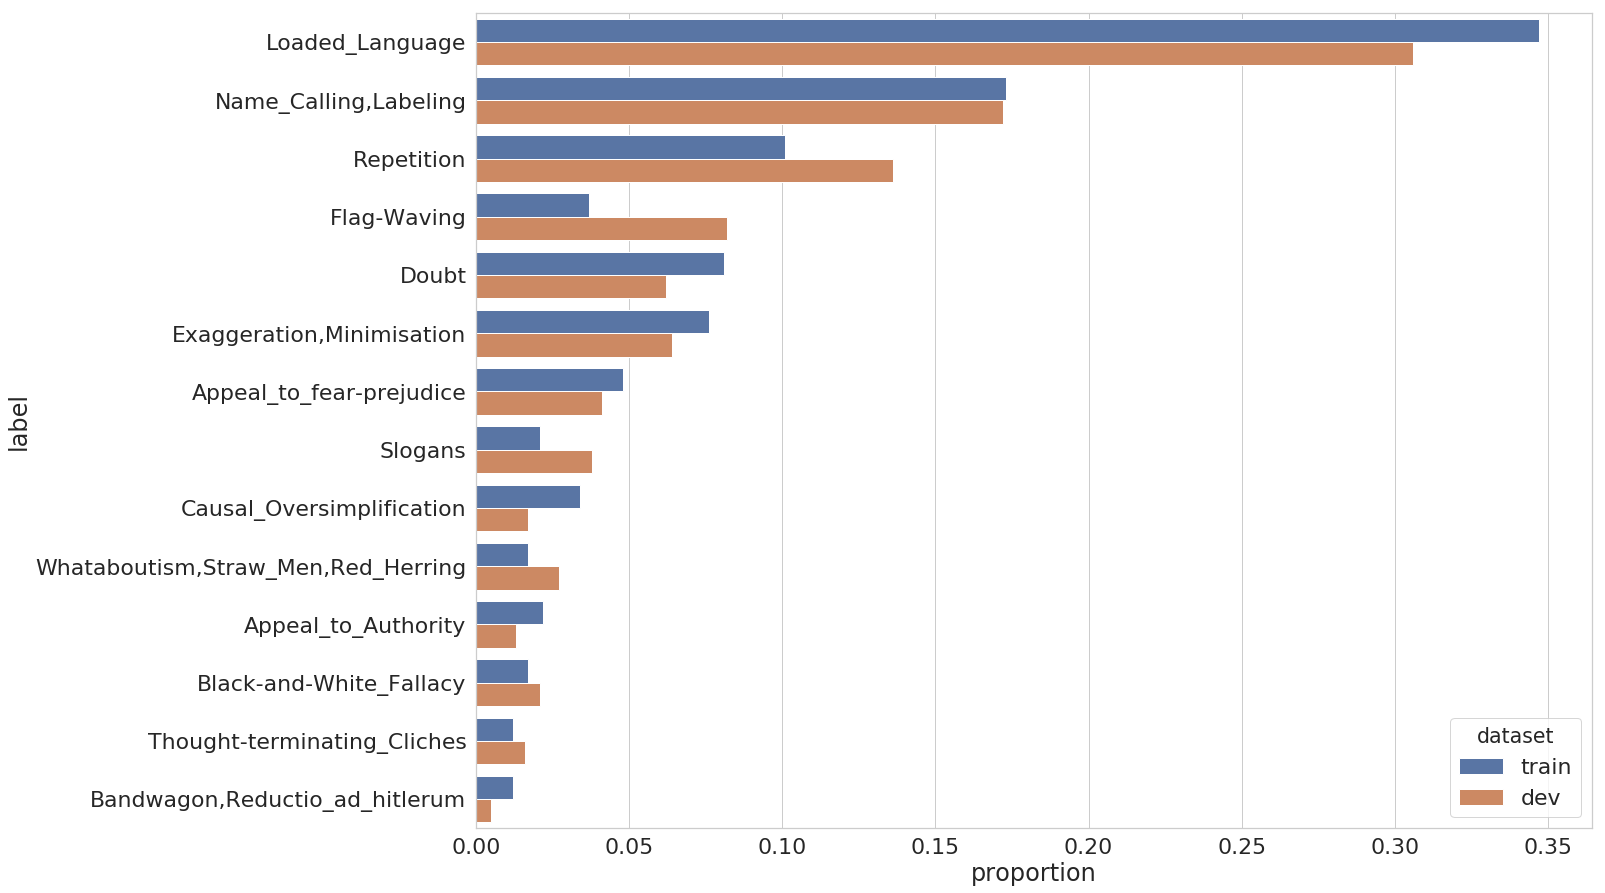

In [10]:
plot_class_proportions(train_df, dev_df)
# Save the figure to the file
plt.savefig("proportion-bars.svg", format="svg", bbox_inches='tight')